# 動力学モデル
## チャネル動態の動力学的表現
指数関数型シナプスとモデルの振る舞いはほぼ同一だが, 式の構成が少し異なるモデルとして**動力学モデル** (Kinetic model, またはMarkov kinetic model)がある ([Destexhe et al., 1994](https://link.springer.com/article/10.1007/BF00961734); [Destexhe et al., 2002](http://cns.iaf.cnrs-gif.fr/files/handbook98.pdf))．動力学モデルはHHモデルのゲート変数の式と類似した式で表される．このモデルではチャネルが開いた状態(Open)と閉じた状態(Close), および神経伝達物質(neurotransmitter)の放出状態(T)の2つの要素に関する状態がある．また, 閉$\to$開の反応速度を$\alpha$, 開$\to$閉の反応速度を$\beta$とする．このとき，これらを表す状態遷移の式は次のようになる．

$$
\begin{equation}
\text{Close}+\text{T}  \underset{\beta}{\overset{\alpha}{\rightleftharpoons}}\text{Open}    
\end{equation}
$$

ここで, シナプス動態を$r$とすると

$$
\begin{equation}
\frac{dr}{dt}=\alpha T (1-r) - \beta r
\end{equation}
$$

となる．ただし, Tはシナプス前細胞が発火したときにインパルス的に1だけ増加するとする．また, $\alpha, \beta$は速度なので, 時定数の逆数であることに注意しよう． $\alpha=2000 \text{ms}^{-1}$, $\beta=200 \text{ms}^{-1}$とすると, シナプス動態は次のようになる．

In [1]:
using PyPlot, PyCall
rcParams = PyDict(plt."rcParams")
rcParams["axes.spines.top"], rcParams["axes.spines.right"] = false, false;

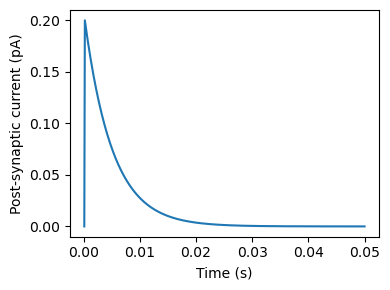

In [2]:
dt = 1e-4 # タイムステップ (sec)
α, β = 1/5e-4, 1/5e-3
T = 0.05 # シミュレーション時間 (sec)
nt = Int(T/dt) # シミュレーションの総ステップ

r = zeros(nt)

for t in 1:nt-1
    spike = ifelse(t == 1, 1, 0)
    r[t+1] = r[t] + dt * (α*spike*(1-r[t]) - β*r[t])
end

time = (1:nt)*dt
figure(figsize=(4, 3))
plot(time, r)
xlabel("Time (s)"); ylabel("Post-synaptic current (pA)")
tight_layout()

## Hodgkin-Huxleyモデルにおけるシナプスモデル
これまで明示的にスパイクの発生が表現されたモデルを用いてきたが，HHモデルでは単なる膜電位の変数があるのみである．ここでは前述した動力学的モデルを用いてHHモデルにおけるシナプス動態の記述を行う ([Destexhe et al., 1994](https://www.mitpressjournals.org/doi/10.1162/neco.1994.6.1.14); [Batista et al., 2014](https://www.sciencedirect.com/science/article/pii/S0378437114004592))．

$r_{j}$を$j$番目のニューロンのpre-synaptic dynamicsとすると，$r_{j}$は次式に従う．

$$
\frac{\mathrm{d} r_{j}}{\mathrm{d} t}=\left(\frac{1}{\tau_{r}}-\frac{1}{\tau_{d}}\right) \frac{1-r_{j}}{1+\exp \left(-V_{j}+V_{0}\right)}-\frac{r_{j}}{\tau_{d}}
$$

ただし，時定数 $\tau_r=0.5, \tau_d = 8$ (ms), 反転電位 $V_0 = -20$ (mV)とする．前節で既に$r$の描画は行ったが，パルス波を印加した場合の挙動を確認する．

In [3]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack

@kwdef struct HHParameter{FT}
    Cm::FT = 1.0 # 膜容量(uF/cm^2)
    gNa::FT = 120.0 # Na+ の最大コンダクタンス(mS/cm^2)
    gK::FT = 36.0 # K+ の最大コンダクタンス(mS/cm^2)
    gL::FT = 0.3 # 漏れイオンの最大コンダクタンス(mS/cm^2)
    ENa::FT = 50.0 # Na+ の平衡電位(mV)
    EK::FT = -77.0 # K+ の平衡電位(mV)
    EL::FT = -54.387 #漏れイオンの平衡電位(mV)
    tr::FT = 0.5 # ms
    td::FT = 8.0 # ms
    invtr::FT = 1.0 / tr
    invtd::FT = 1.0 / td
    v0::FT = -20.0 # mV
end

@kwdef mutable struct HH{FT}
    param::HHParameter = HHParameter{FT}()
    N::Int32
    v::Vector{FT} = fill(-65.0, N)
    m::Vector{FT} = fill(0.05, N)
    h::Vector{FT} = fill(0.6, N)
    n::Vector{FT} = fill(0.32, N)
    r::Vector{FT} = zeros(N)
end

function updateHH!(variable::HH, param::HHParameter, I::Vector, dt)
    @unpack N, v, m, h, n, r = variable
    @unpack Cm, gNa, gK, gL, ENa, EK, EL, tr, td, invtr, invtd, v0= param
    @inbounds for i = 1:N
        m[i] += dt * ((0.1(v[i]+40.0)/(1.0 - exp(-0.1(v[i]+40.0))))*(1.0 - m[i]) - 4.0exp(-(v[i]+65.0) / 18.0)*m[i])
        h[i] += dt * ((0.07exp(-0.05(v[i]+65.0)))*(1.0 - h[i]) - 1.0/(1.0 + exp(-0.1(v[i]+35.0)))*h[i])
        n[i] += dt * ((0.01(v[i]+55.0)/(1.0 - exp(-0.1(v[i]+55.0))))*(1.0 - n[i]) - (0.125exp(-0.0125(v[i]+65)))*n[i])
        v[i] += dt / Cm * (I[i] - gNa * m[i]^3 * h[i] * (v[i] - ENa) - gK * n[i]^4 * (v[i] - EK) - gL * (v[i] - EL))
        r[i] += dt * ((invtr - invtd) * (1.0 - r[i])/(1.0 + exp(-v[i] + v0)) - r[i] * invtd)
    end
end

updateHH! (generic function with 1 method)

シミュレーションを実行する．

In [4]:
T = 50 # ms
dt = 0.01f0 # ms
nt = Int32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
I = repeat(5f0 * ((t .> 10) - (t .> 15)), 1, N)  # injection current

# 記録用
varr, rarr = zeros(Float32, nt, N), zeros(Float32, nt, N)
# modelの定義
neurons = HH{Float32}(N=N)

# simulation
@time for i = 1:nt
    updateHH!(neurons, neurons.param, I[i, :], dt)
    varr[i, :], rarr[i, :] = neurons.v, neurons.r
end

  0.169165 seconds (397.92 k allocations: 22.435 MiB, 94.96% compilation time)


描画してみる．

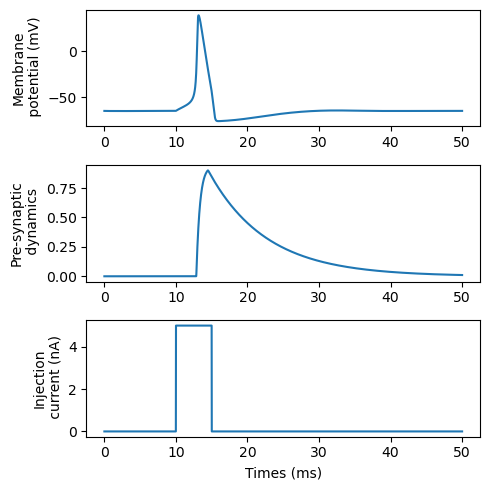

In [5]:
figure(figsize=(5,5))
subplot(3,1,1); plot(t, varr[:, 1]); ylabel("Membrane\n potential (mV)")
subplot(3,1,2); plot(t, rarr[:, 1]); ylabel("Pre-synaptic\n dynamics")
subplot(3,1,3); plot(t, I[:, 1]); xlabel("Times (ms)"); ylabel("Injection\n current (nA)")
tight_layout()